In [12]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import plotly.express as px

In [4]:
file_path = 'Meteorite_Landings.csv' 
meteorite_data = pd.read_csv(file_path)

# **Meteorite Mapping: Evaluating the Efficacy and limits of Static and Interactive Cartography**

## **Introduction**

Welcome to this Jupyter Notebook and the project in general. These Notebooks are designed to run and display code before integrating it into Streamlit. The Notebooks and the Streamlit code use a folder containing various modules called "Modules". Modules have their own needed libraries in their respective file as well as some explanation about codes. Multiple Notebooks are included in this project to build diverse codes and incorporate numerous features into the final model. Additionally, the extensive memory and processing power required to initialize *Folium* and plot points, necessitated dividing the project into different Notebooks. The Notebooks should be read in the following order:

- **Intro_analysis**: This Notebook provides a comprehensive explanation of data inspection and cleaning, along with static visualizations.
- **1HeatMap+map1**: The first use of *Folium* is showcased here, featuring a Heatmap and a display of the entire clustered dataset.
- **2ColourPoints**: This Notebook re-displays the entire dataset in clusters, with each point color-coded according to the meteorite type.
- **4NotWorking**: The first part of this Notebook displays a map with colored points and clusters, and includes an initial attempt to integrate a search bar. However, due to some issues, the code does not function correctly. We attempt to resolve this by displaying all the data. **NOTE**: This last code should not be run on average computers as it is too resource-intensive and may cause Nuvolos to crash. It illustrates what could have been achieved if the full dataset was displayed.
- **5Input**: To interact with the data, this Notebook creates a map that prompts the user for the number of inputs to display. To make the search bar functional, we make some trade-offs between previously computed features.
- **6Random**: Similar to the previous Notebook, but the number of inputs is selected directly in the code.
- **7Draw**: This final Notebook combines the codes from the previous Notebooks. It includes search features, the ability to hover over points to display meteorite names without clicking, and a drawing capability.

The interactive part is then adapted to fit on Streamlit. 

## **Motivation**

Meteorites, the surviving fragments from meteoroids that have collided with Earth, provide invaluable insights into the early solar system. Studying their distribution, frequency, and impact locations can enhance our understanding of cosmic phenomena and Earth's geological history. Therefore this project studies how mapping could be used and implement in coding environments, and evaluates the efficacy and limits of static and interactive mapping. 

## **Data description**

This project utilizes a dataset provided by the NASA and hosted on [Data.gov](https://data.gov/), which encompasses records of meteorite landings across the globe. 

The data is formatted in various files format, but in this project we will use the csv file due to it’s simple compatibility with Jupyter and Streamlit. The dataset is composed of some 45,000 unique observations. Indeed a meteorite can only land once on the Earth. The columns are composed of : 

1. Name: each meteorite has its own name, usually the name of the place where it fell
2. ID: each meteorite has a unique identifier 
3. Nametype: no official meaning, but all the dataset is marked by valid 
4. Recclass: meteorites are classified according to their composition
5. Mass (g): the weight of the meteorite in grams
6. Fall: two possibilities : 
    - Fell : observed meteorites as they fall to Earth
    - Found: not observed but discovered later 
7. Year: when the meteorite either fell to Earth or was found, depending on the context
8. Reclat : recorded latitude 
9. Reclong : recorded longitude 
10. GeoLocation : Mix of latitude and longitude 

## **Data Inspection and Preliminaries**  

In [5]:
meteorite_data.head()

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)"


In [6]:
column_types = meteorite_data.dtypes
print(column_types)

name            object
id               int64
nametype        object
recclass        object
mass (g)       float64
fall            object
year           float64
reclat         float64
reclong        float64
GeoLocation     object
dtype: object


### Missing values
##### In order to work properly with the data it is important to filter information, especially the missing and zero values of each column, look for duplicates, and how many unique values we have for each column. We have to be careful for the GeoLocation column, because it is composed of a tuple which is composed of (reclat, reclong). Therefore the following code will show that there are no zero values in the column GeoLocation but this is false. In order to find how many GeoLocation lines have the values (0.0, 0.0) we can count of many lines have 0.0 for reclat and 0.0 for reclong. 

In [7]:
from Modules.quality import DataQuality
dq = DataQuality(meteorite_data)
dq.print_missing_values() 
dq.print_zero_values()   
dq.count_zero_lat_long()  
dq.print_duplicate_rows()
dq.print_unique_values() 

Missing Values:
name              0
id                0
nametype          0
recclass          0
mass (g)        131
fall              0
year            291
reclat         7315
reclong        7315
GeoLocation    7315
dtype: int64

Zero Values in Each Column:
name              0
id                0
nametype          0
recclass          0
mass (g)         19
fall              0
year              0
reclat         6438
reclong        6214
GeoLocation       0
dtype: int64
Count of rows with 'reclat' and 'reclong' both equal to 0: 6214
Duplicate Rows:
0

Unique Values:
{'name': 45716, 'id': 45716, 'nametype': 2, 'recclass': 466, 'mass (g)': 12576, 'fall': 2, 'year': 265, 'reclat': 12738, 'reclong': 14640, 'GeoLocation': 17100}


This code displays clearly a few problems in the dataset: 

1. There are missing values in a few columns. For the year, it is intuitive that the meteorite could not be dated by scientists. However, the missing values for mass and location are more challenging to explain due to their nature. The data provided by NASA is not clearly explained, so we can only make assumptions. For the mass, one possibility is that the landing site was discovered, but the meteorite was no longer present, making it impossible to weigh. Another assumption is that the meteorite exploded upon landing, leaving no remnants to be found.

To better understand the extent of these missing values, we can verify how many rows have missing values for Mass and GeoLocation.


In [8]:
missing_count = meteorite_data[meteorite_data['mass (g)'].isnull() & meteorite_data['GeoLocation'].isnull()].shape[0]
print("Count of rows with missing values in both 'mass (g)' and 'GeoLocation':", missing_count)


Count of rows with missing values in both 'mass (g)' and 'GeoLocation': 12


The output shows that only 12 meteorites have missing values for the mass and the location. It is not clear why in the data some values are missing.

2. There are many columns with the value 0. As stated before NASA does not give a clear explanation on the data page for these values, but an assumption could be that the mass of the meteorite found is so close to 0 that it is easier to weight it to 0. However the values 0 in the GeoLocation column are confusing. It means that 6214 values fell into the exact same location. According to some documentation these meteorites have been discovered in Antartica and errors snuck into the dataset which classified the data at (0.0, 0.0). For this reason we will work without these values.

The following Python code defines the MeteoriteData class using the Pandas library to manage meteorite data efficiently. It initializes with a file_path, allowing flexible data input, and provides methods like *load_data* to load the dataset into a DataFrame, and count_unique_recclass_values to count unique meteorite classifications after checking if data is loaded. This approach prevents errors from operations on unloaded data and enhances reusability. 
We use this code to explore the dataset and see how many unique values there is and how they called. 

In [9]:
class MeteoriteData:
    def __init__(self, file_path):
        self.file_path = file_path
        self.meteorite_data = None

    def load_data(self):
        self.meteorite_data = pd.read_csv(self.file_path)

    def count_unique_recclass_values(self):
        if self.meteorite_data is None:
            print("Error: Data not loaded. Please call the load_data method first.")
            return

        unique_values_counts = self.meteorite_data['recclass'].value_counts().reset_index()
        unique_values_counts.columns = ['recclass', 'count']
        return unique_values_counts


meteorite_dataset = MeteoriteData(file_path)
meteorite_dataset.load_data()

unique_recclass_counts = meteorite_dataset.count_unique_recclass_values()
print("Unique values and their counts in the 'recclass' column:")
print(unique_recclass_counts)

Unique values and their counts in the 'recclass' column:
    recclass  count
0         L6   8285
1         H5   7142
2         L5   4796
3         H6   4528
4         H4   4211
..       ...    ...
461      EL7      1
462   CH/CBb      1
463    H/L~4      1
464  LL3.7-6      1
465     L/LL      1

[466 rows x 2 columns]


### Meteorite Classification
We see in the previous code that there are 466 unique values, which means that, as of today, scientists have classified meteorites according to 466 different compositions.

Meteorites are classified into main groups based on their compositions and structures. Studies tend to disagree on classification methodes, but here is a concise overview of the classifications:

1. **Stony Meteorites**:
   - **Chondrites**: These contain small spherical inclusions known as chondrules.
     - **Carbonaceous Chondrites (CC)**: Includes subgroups like CI1 (Ivuna), CM2 (Mighei), and others.
     - **Enstatite Chondrites (EC)**: Ranges from EH3 to EH5 (EH group) and EL3 to EL6 (EL group).
     - **Ordinary Chondrites (OC)**: Includes H, L, LL groups, and unclassified types.
     - **Kakangari Chondrites (KC)**: Notably the K3 (Kakangari group).
   - **Achondrites (AC)**: Lack chondrules and include types like Angrites (ANG), Eucrites (EUC), and others.
   - **Primitive Achondrites (PA)**: Such as Acapulcoites (ACA) and Winonaites (WIN).

2. **Iron Meteorites**:
   - Classified by their nickel-iron alloy composition, with groups ranging from IA to IC and ungrouped irons.

3. **Stony-Iron Meteorites**:
   - **Mesosiderites (MES)** and **Pallasites (PAL)**, with subgroups like Eagle station pallasite (ES PAL).
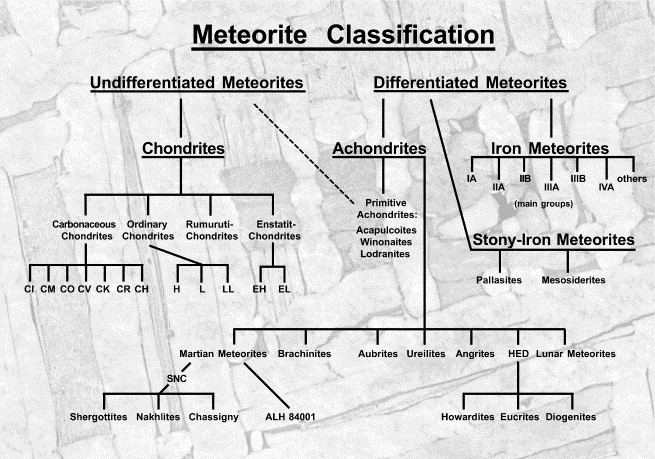 

*More information about the image and their classification on [Meteorites Classification](https://www.sciencedirect.com/science/article/pii/S0032063301000265)*

The following code defines a function that categorizes the various meteorite types listed in the 'reclass' column into broader family groups. It then applies this classification function to create a new column in the dataset, assigning each meteorite to its respective family group.

In [10]:
from Modules.meteorite_classification import classify_meteorites
meteorite_data['classification_group'] = meteorite_data['recclass'].apply(classify_meteorites) #apply the ouput of the module to the data

classification_counts = meteorite_data['classification_group'].value_counts().reset_index()
classification_counts.columns = ['classification_group', 'count']
print("Counts for each classification group:")
print(classification_counts)

Counts for each classification group:
                  classification_group  count
0                                   OC  40557
1                                   CC   1559
2                                   EC   1218
3                                   IR   1069
4                                   AC    800
5                                   SI    281
6                                   PA    121
7   Unclassified/ ungrouped meteorites     75
8                                   KC     24
9                              Unknown      7
10                              Relict      4
11                     Lunar meteorite      1


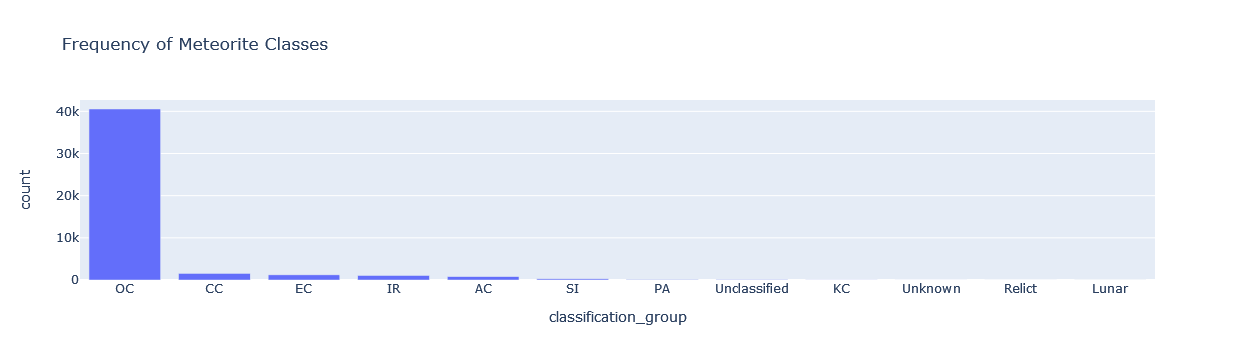

In [20]:
classification_counts = {
    'classification_group': ['OC', 'CC', 'EC', 'IR', 'AC', 'SI', 'PA', 'Unclassified', 'KC', 'Unknown', 'Relict', 'Lunar'],
    'count': [40557, 1559, 1218, 1069, 800, 281, 121, 75, 24, 7, 4, 1]
}

# Create a histogram
fig = px.bar(classification_counts, x='classification_group', y='count', title='Frequency of Meteorite Classes')
fig.show()


To confirm the correct classification of the data, we need to check that the 'recclass' column has been accurately filtered into the newly created column. We aim to determine whether any meteorite labeled differently from "unknown" has been incorrectly classified as "unknown" or missed during the classification process. Thus, all entries in the 'recclass' column not labeled as "unknown" should be properly classified in the new column.

In [21]:
unknown_meteorites = meteorite_data[meteorite_data['classification_group'] == 'Unknown']
print("Meteorites with unknown classification:")
print(unknown_meteorites)


Meteorites with unknown classification:
                  name     id nametype recclass  mass (g)   fall    year  \
12     Aire-sur-la-Lys    425    Valid  Unknown       NaN   Fell  1769.0   
562             Lusaka  14759    Valid  Unknown       NaN   Fell  1951.0   
5516              Cook   5420    Valid  Unknown       NaN  Found     NaN   
17288   Johnny's Donga  12196    Valid  Unknown       NaN  Found  1965.0   
17378     Korrelocking  12348    Valid  Unknown       NaN  Found  1937.0   
31098          Palermo  18076    Valid  Unknown       NaN  Found  1966.0   
31147    Paso Rio Mayo  18111    Valid  Unknown       NaN  Found  1968.0   

         reclat    reclong             GeoLocation classification_group  
12     50.66667    2.33333     (50.66667, 2.33333)              Unknown  
562    -7.21667   29.43333    (-7.21667, 29.43333)              Unknown  
5516        NaN        NaN                     NaN              Unknown  
17288 -30.33333  126.36667  (-30.33333, 126.36667)     

## **Static visualization**

Let's first run all the data (even the one that is wrong an not filtered) on a 2D static and non-interactrive map in order to see how the data displays and if there is anything wrong or suspect.

<AxesSubplot:xlabel='reclong', ylabel='reclat'>

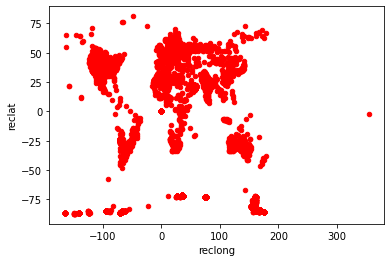

In [13]:
meteorite_data.plot(x="reclong", y="reclat", kind="scatter", color="red")

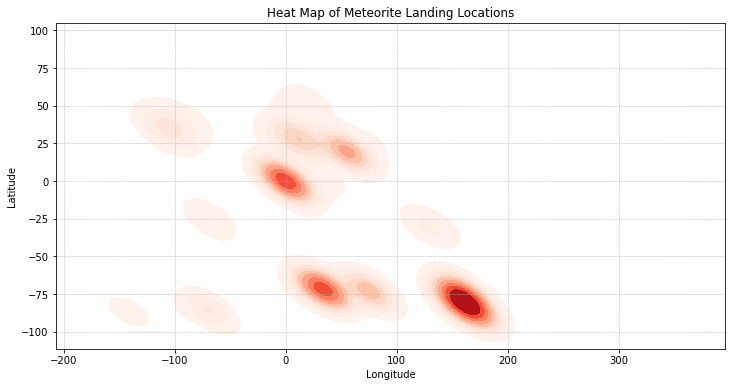

In [26]:
from Modules.Heatmap import MeteoriteHeatMap
heatmap_visualizer = MeteoriteHeatMap(meteorite_data)
heatmap_visualizer.plot_heat_map()

By definition latitude is bounded in degrees within the range [-90, 90] and longitude is bouned in degrees within the range [-180, 180)]. On the map it is clearly noticeable that there is some outliers data, that can be due to various reasons such as mistakes or data processing issues. We need to get rid of these values

In [15]:
from Modules.meteorite_outliers import MeteoriteOutliers

outlier_detector = MeteoriteOutliers(meteorite_data)

outlier_detector.report_outliers()

Number of outliers in latitude: 0
Number of outliers in longitude: 1
Total number of outliers: 1
                   name     id nametype           recclass  mass (g)   fall  \
22946  Meridiani Planum  32789    Valid  Iron, IAB complex       NaN  Found   

         year   reclat    reclong            GeoLocation classification_group  
22946  2005.0 -1.94617  354.47333  (-1.94617, 354.47333)                   IR  


<AxesSubplot:xlabel='reclong', ylabel='reclat'>

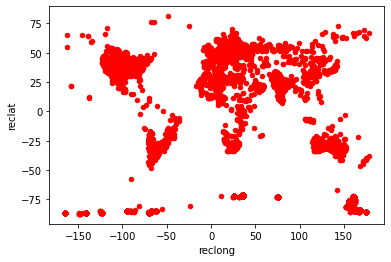

In [16]:
from Modules.cleanedata import Cleaner 
df = pd.read_csv('Meteorite_Landings.csv') 

cleaner = Cleaner(df)
cleaned_data = cleaner.clean_data()
cleaned_data['classification_group'] = meteorite_data['recclass'].apply(classify_meteorites)
cleaned_data.plot(x="reclong", y="reclat", kind="scatter", color="red")

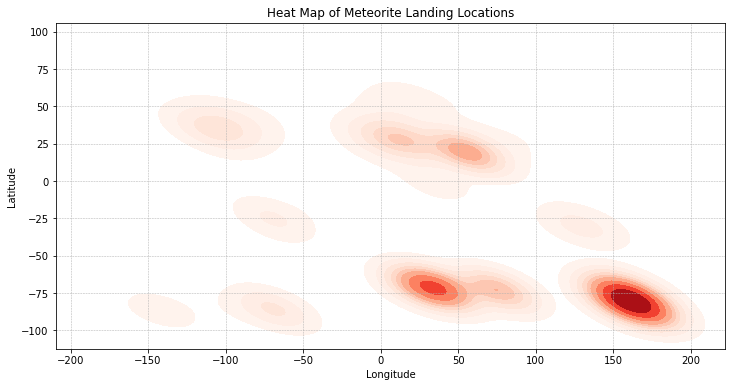

In [19]:
from Modules.Filtered_heatmap import MeteoriteHeatMap
heatmap_visualizer = MeteoriteHeatMap(cleaned_data)

heatmap_visualizer.plot_heat_map()

The cleaning has been succesfully done, represented by the new cleaned displays

The next module extends our meteorite data visualization by incorporating a color-coded classification system, allowing for the immediate identification of different meteorite types on a 2D map. An accompanying interactive HTML file provides a legend and detailed explanations of the color codes, enhancing the educational and analytical utility of the visualization. This upgrade facilitates a more nuanced exploration of the spatial distribution of meteorite landings globally.

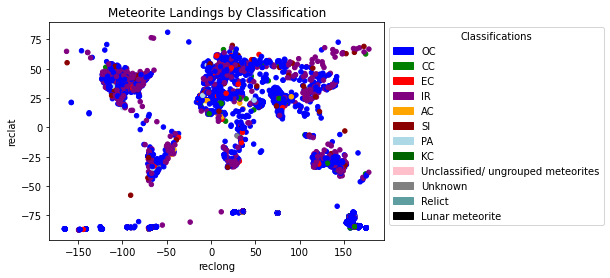

In [17]:
from Modules.viz2D_colour import MeteoriteVisualization
viz = MeteoriteVisualization(cleaned_data)
viz.plot_meteorite_landings()

Or if you want the map but bigger and without legends and with lines : 

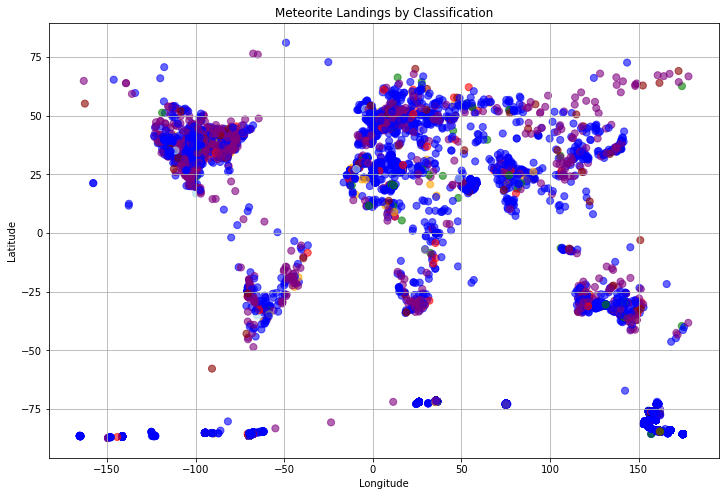

In [18]:
from Modules.withoutHTML2D import MeteoriteMap
map_visualizer = MeteoriteMap(cleaned_data)

map_visualizer.plot_data()

Following these visual representations, we have reached the limitations of static 2D displays. The map is so densely colored with points that it nearly obscures the continents entirely. This density prevents effective zooming and does not display any feature of the points. Additionally, many points are concentrated in the same or nearby locations, causing them to overlap. This overlap creates a layered effect that hinders proper visibility and analysis.